## **Data Loading and Pre-Processing**

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the datasets with the specified encoding
movies = pd.read_csv('/kaggle/input/movies-dataset/ml-1m/movies.dat', sep='::', header=None, names=['movieid', 'title', 'genres'], engine='python', encoding='ISO-8859-1')
ratings = pd.read_csv('/kaggle/input/movies-dataset/ml-1m/ratings.dat', sep='::', header=None, names=['userid', 'movieid', 'rating', 'timestamp'], engine='python', encoding='ISO-8859-1')
users = pd.read_csv('/kaggle/input/movies-dataset/ml-1m/users.dat', sep='::', header=None, names=['userid', 'gender', 'age', 'occupation', 'zipcode'], engine='python', encoding='ISO-8859-1')

# Convert timestamp to datetime for aggregation
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Merge datasets
movies['year'] = movies['title'].str.extract(r'(\d{4})').astype(float)
rating_movies = pd.merge(ratings, movies, on='movieid', how='left')
final_data = pd.merge(rating_movies, users, on='userid', how='left')
current_year = pd.Timestamp.now().year
valid_year_range = (1900, current_year)

# Filter rows with valid years
final_data = final_data[(final_data['year'] >= valid_year_range[0]) & (final_data['year'] <= valid_year_range[1])]

# Handle missing values
movies.dropna(inplace=True)
ratings.dropna(inplace=True)
users.dropna(inplace=True)
final_data.dropna(inplace=True)

# 1. Discretization
# Discretize 'rating' into Low, Medium, and High categories
bins = [0, 2, 3, 5]
labels = ['Low', 'Medium', 'High']
final_data['rating_category'] = pd.cut(final_data['rating'], bins=bins, labels=labels, right=True)

# Check the distribution of the discretized ratings
rating_distribution = final_data['rating_category'].value_counts()
print("Discretized Rating Distribution:")
print(rating_distribution)


Discretized Rating Distribution:
rating_category
High      574893
Medium    260958
Low       163592
Name: count, dtype: int64


In [96]:
# 2. Sampling
sampled_data = final_data.groupby('rating_category', group_keys=False).apply(lambda x: x.sample(frac=0.7))
print("Sampled Data Distribution:")
sampled_data['rating_category'].value_counts()

/tmp/ipykernel_30/2425315462.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_data = final_data.groupby('rating_category', group_keys=False).apply(lambda x: x.sample(frac=0.7))
/tmp/ipykernel_30/2425315462.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = final_data.groupby('rating_category', group_keys=False).apply(lambda x: x.sample(frac=0.7))


Sampled Data Distribution:


rating_category
High      402425
Medium    182671
Low       114514
Name: count, dtype: int64

In [97]:
# 3. Aggregation
ratings_by_year = final_data.groupby('year')['rating'].mean().reset_index()
print("Average Ratings by Year:")
ratings_by_year

Average Ratings by Year:


,year,rating
0,1900.0,2.950000
1,1919.0,3.466667
2,1920.0,3.666667
3,1921.0,3.790323
4,1922.0,3.991597
...,...,...
79,1998.0,3.461354
80,1999.0,3.496168
81,2000.0,3.370538
82,2001.0,4.068765


In [98]:
# 4. Dimensionality Reduction / Feature Selection
features_to_drop = ['zipcode', 'timestamp']
final_data_reduced = final_data.drop(columns=features_to_drop)
print("Final Data Info:")
final_data_reduced.info()

Final Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 999443 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   userid           999443 non-null  int64   
 1   movieid          999443 non-null  int64   
 2   rating           999443 non-null  int64   
 3   title            999443 non-null  object  
 4   genres           999443 non-null  object  
 5   year             999443 non-null  float64 
 6   gender           999443 non-null  object  
 7   age              999443 non-null  int64   
 8   occupation       999443 non-null  int64   
 9   rating_category  999443 non-null  category
dtypes: category(1), float64(1), int64(5), object(3)
memory usage: 77.2+ MB


In [99]:
final_data.head()

,userid,movieid,rating,timestamp,title,genres,year,gender,age,occupation,zipcode,rating_category
0,1,1193,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest (1975),Drama,1975.0,F,1,10,48067,High
1,1,661,3,2000-12-31 22:35:09,James and the Giant Peach (1996),Animation|Children's|Musical,1996.0,F,1,10,48067,Medium
2,1,914,3,2000-12-31 22:32:48,My Fair Lady (1964),Musical|Romance,1964.0,F,1,10,48067,Medium
3,1,3408,4,2000-12-31 22:04:35,Erin Brockovich (2000),Drama,2000.0,F,1,10,48067,High
4,1,2355,5,2001-01-06 23:38:11,"Bug's Life, A (1998)",Animation|Children's|Comedy,1998.0,F,1,10,48067,High


In [4]:
final_data.describe()

,userid,movieid,rating,timestamp,year,age,occupation
count,1.000209e+06,1.000209e+06,1.000209e+06,1000209,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,2000-10-22 19:41:35.404665856,1.987296e+03,2.973831e+01,8.036138e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,2000-04-25 23:05:32,1.600000e+03,1.000000e+00,0.000000e+00
25%,1.506000e+03,1.030000e+03,3.000000e+00,2000-08-03 11:37:17,1.982000e+03,2.500000e+01,2.000000e+00
50%,3.070000e+03,1.835000e+03,4.000000e+00,2000-10-31 18:46:46,1.992000e+03,2.500000e+01,7.000000e+00
75%,4.476000e+03,2.770000e+03,4.000000e+00,2000-11-26 06:42:19,1.997000e+03,3.500000e+01,1.400000e+01
max,6.040000e+03,3.952000e+03,5.000000e+00,2003-02-28 17:49:50,9.000000e+03,5.600000e+01,2.000000e+01
std,1.728413e+03,1.096041e+03,1.117102e+00,NaN,4.308257e+01,1.175198e+01,6.531336e+00


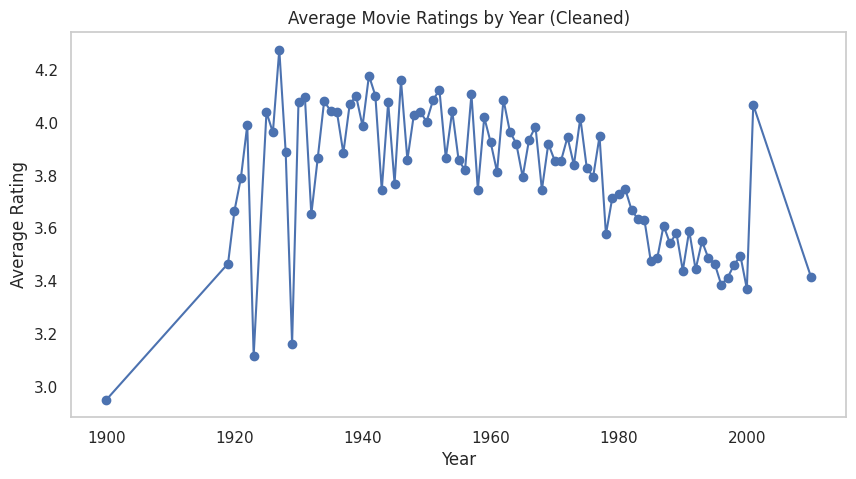

In [91]:
# Visualization of ratings over cleaned years
plt.figure(figsize=(10, 5))
plt.plot(ratings_by_year['year'], ratings_by_year['rating'], marker='o', linestyle='-', color='b')
plt.title('Average Movie Ratings by Year (Cleaned)')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid()
plt.show()

## **Exploratory Data Analysis**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


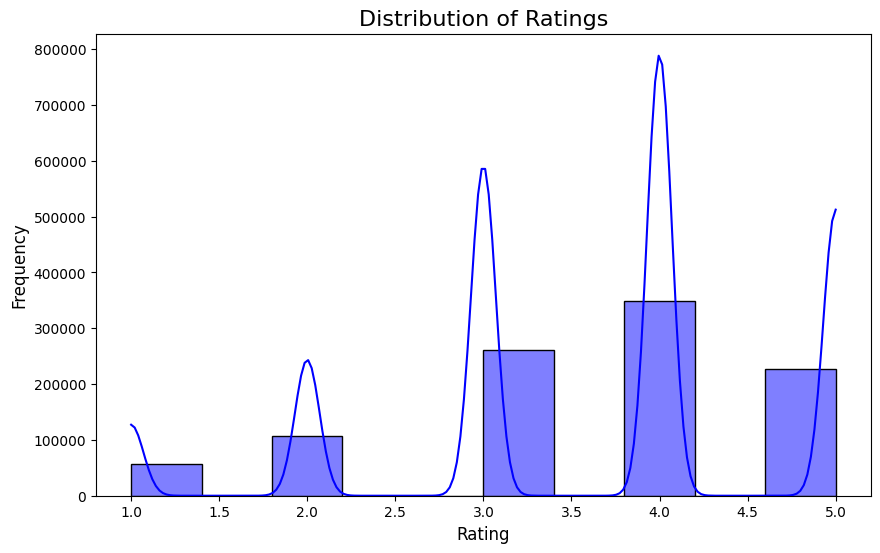

In [5]:
# Plot the distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(rating['rating'], bins=10, kde=True, color='blue')
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

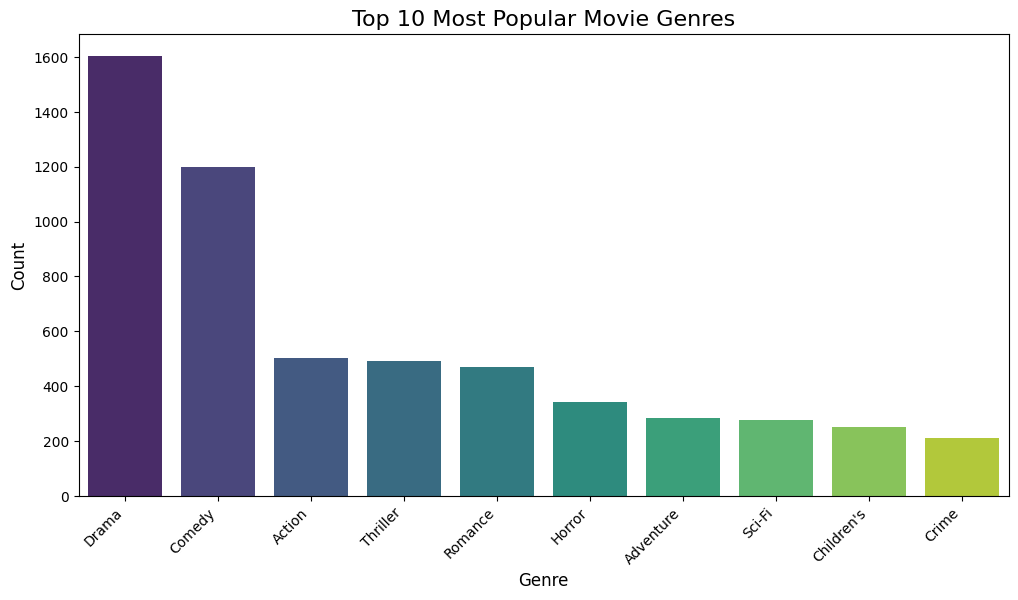

In [6]:
# Frequency of genres from movies
genres_series = movies['genres'].str.split('|', expand=True).stack()
genre_counts = genres_series.value_counts()

# Plot the top 10 most common genres
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.head(10).index, y=genre_counts.head(10).values, palette='viridis')
plt.title('Top 10 Most Popular Movie Genres', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()


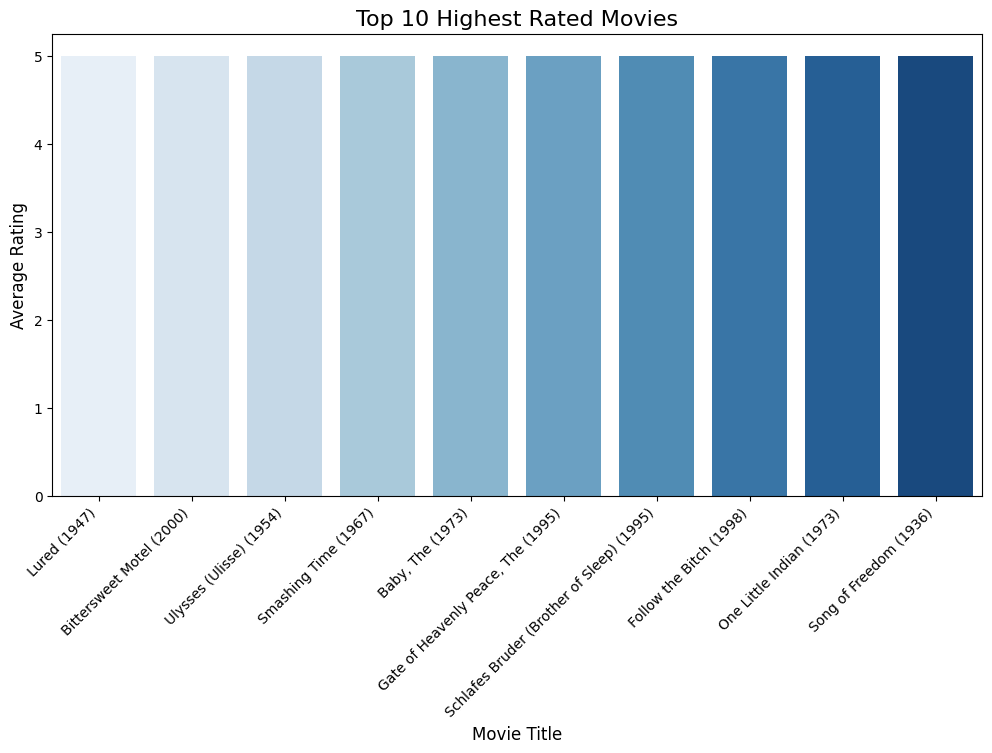

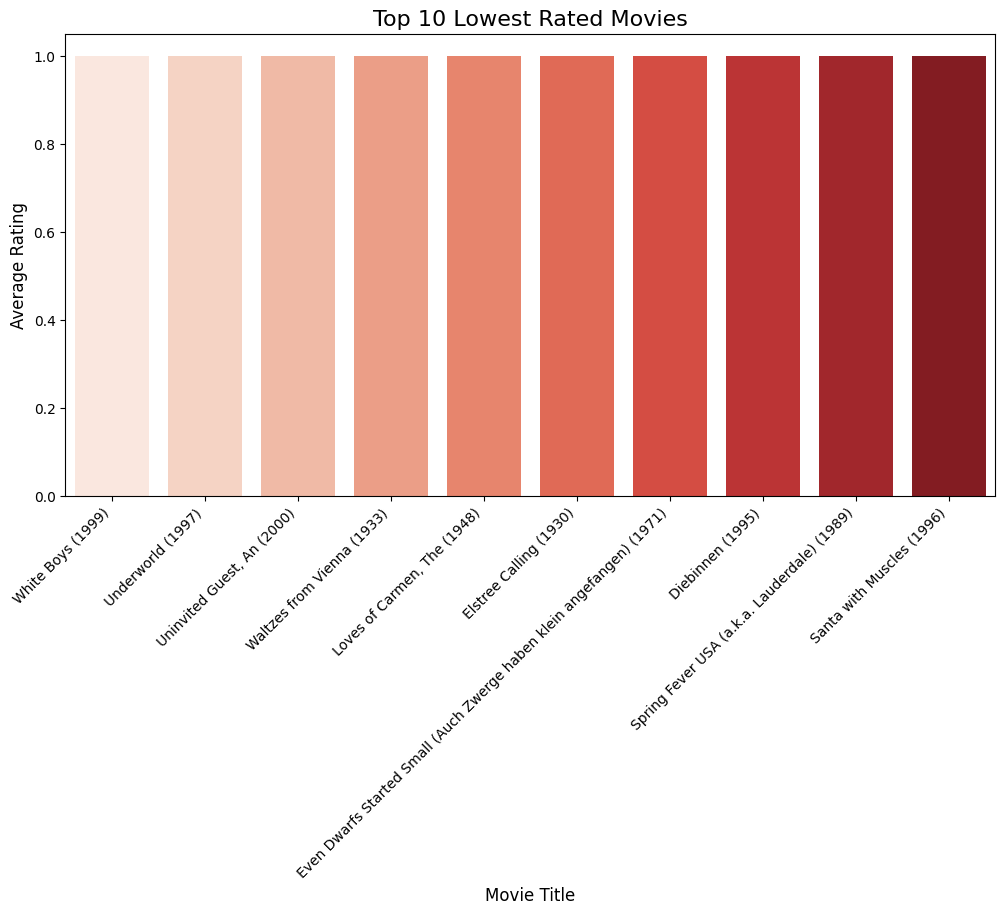

In [7]:
# Calculate average rating for each movie
avg_movie_ratings = rating_movies.groupby('title')['rating'].mean()

# Top 10 highest-rated movies
top_movies = avg_movie_ratings.sort_values(ascending=False).head(10)

# Bottom 10 lowest-rated movies
bottom_movies = avg_movie_ratings.sort_values().head(10)

# Plot the top 10 highest-rated movies
plt.figure(figsize=(12, 6))
sns.barplot(x=top_movies.index, y=top_movies.values, palette='Blues')
plt.title('Top 10 Highest Rated Movies', fontsize=16)
plt.xlabel('Movie Title', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

# Plot the bottom 10 lowest-rated movies
plt.figure(figsize=(12, 6))
sns.barplot(x=bottom_movies.index, y=bottom_movies.values, palette='Reds')
plt.title('Top 10 Lowest Rated Movies', fontsize=16)
plt.xlabel('Movie Title', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


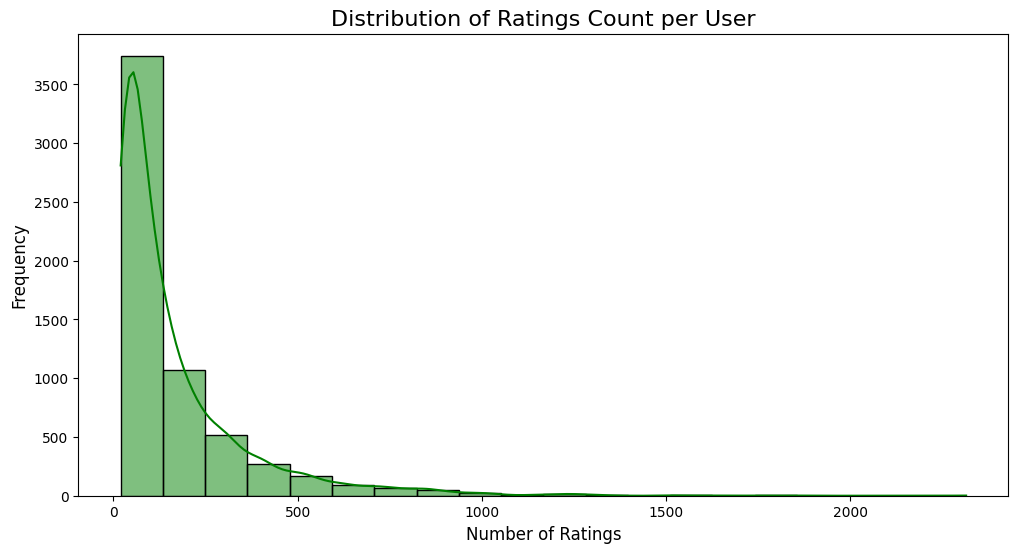

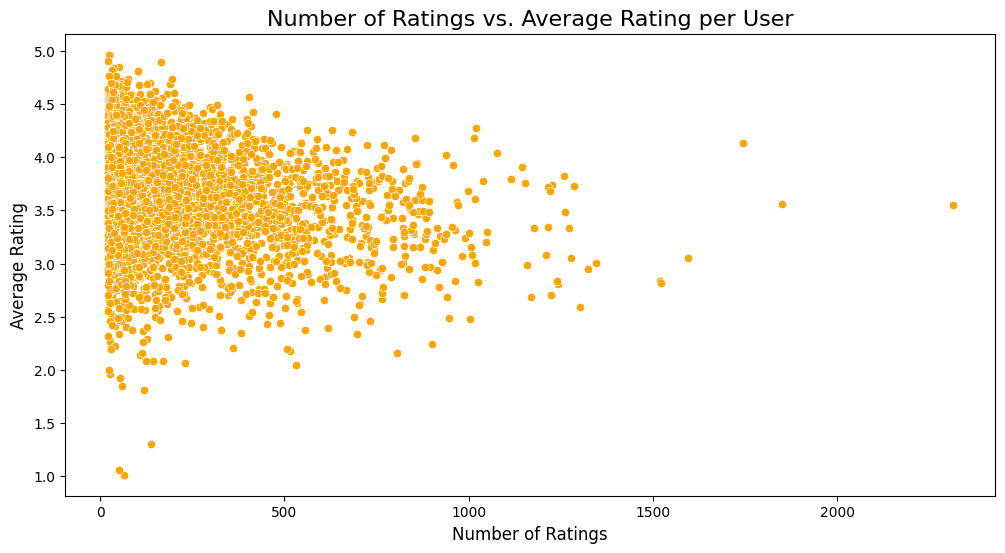

In [8]:
# Calculate the number of ratings per user
user_ratings_count = rating.groupby('userid').size()

# Plot the number of ratings per user
plt.figure(figsize=(12, 6))
sns.histplot(user_ratings_count, bins=20, kde=True, color='green')
plt.title('Distribution of Ratings Count per User', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Scatter plot of number of ratings vs. average rating
avg_user_rating = rating.groupby('userid')['rating'].mean()

plt.figure(figsize=(12, 6))
sns.scatterplot(x=user_ratings_count, y=avg_user_rating, color='orange')
plt.title('Number of Ratings vs. Average Rating per User', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.show()


## **Model Imlementation**

#### **Collavorative Filtering**

In [66]:
def collaborative_filtering(movie_title, top_n=10):
    # Create a pivot table with users as rows and movies as columns
    user_movie_matrix = rating_movies.pivot_table(index='userid', columns='title', values='rating').fillna(0)
    
    # Convert the matrix to a sparse format
    user_movie_sparse = csr_matrix(user_movie_matrix.values)
    
    # Build the model using Nearest Neighbors
    model = NearestNeighbors(metric='cosine', algorithm='brute')
    model.fit(user_movie_sparse.T)  # Transpose to make movies as rows and users as features
    
    # Find the index of the given movie
    if movie_title not in user_movie_matrix.columns:
        raise ValueError(f"The movie '{movie_title}' is not found in the dataset.")
    movie_index = user_movie_matrix.columns.get_loc(movie_title)
    
    # Calculate distances and indices of nearest neighbors
    distances, indices = model.kneighbors(user_movie_sparse.T[movie_index], n_neighbors=top_n + 1)
    
    # Return similar movies
    similar_movies = [user_movie_matrix.columns[i] for i in indices.flatten()][1:]  # Exclude the input movie itself
    return similar_movies


#### **Content based Filtering**

In [73]:
# Content-Based Filtering Model
def content_based_filtering(movie_title, top_n=10):
    # Use genres for similarity calculation
    count_vectorizer = CountVectorizer(tokenizer=lambda x: x.split('|'))
    genre_matrix = count_vectorizer.fit_transform(movies['genres'])
    
    # Compute cosine similarity
    cosine_sim = cosine_similarity(genre_matrix, genre_matrix)
    
    # Find the index of the given movie
    movie_index = movies[movies['title'] == movie_title].index[0]
    
    # Get similarity scores for the movie
    similarity_scores = list(enumerate(cosine_sim[movie_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    
    # Extract the top similar movies
    similar_movies_indices = [i[0] for i in similarity_scores[1:top_n + 1]]  # Exclude the input movie itself
    similar_movies = movies.iloc[similar_movies_indices]['title'].tolist()
    return similar_movies

#### **Recommendation System**

In [75]:
# Unified Recommendation System
def recommend_movies(movie_title, model, top_n=10):
    if model == 'collaborative':
        return collaborative_filtering(movie_title, top_n)
    elif model == 'content':
        return content_based_filtering(movie_title, top_n)
    else:
        raise ValueError("Invalid model type. Choose either 'collaborative' or 'content'.")

# Example Usage
movie_name = "Toy Story (1995)"
print(f"Collaborative Filtering Recommendations for '{movie_name}':")
collab_recommendations = recommend_movies(movie_name, model='collaborative')
print(pd.DataFrame(collab_recommendations))

content_recommendations = recommend_movies(movie_name, model='content')
print(f"\nContent-Based Filtering Recommendations for '{movie_name}':")
print(pd.DataFrame(content_recommendations))

Collaborative Filtering Recommendations for 'Toy Story (1995)':
                                                   0
0                                 Toy Story 2 (1999)
1                               Groundhog Day (1993)
2                                     Aladdin (1992)
3                               Bug's Life, A (1998)
4                          Back to the Future (1985)
5                                        Babe (1995)
6  Star Wars: Episode V - The Empire Strikes Back...
7                                Men in Black (1997)
8                                Forrest Gump (1994)
9                                 Matrix, The (1999)


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Content-Based Filtering Recommendations for 'Toy Story (1995)':
                                                0
0          Aladdin and the King of Thieves (1996)
1                        American Tail, An (1986)
2      American Tail: Fievel Goes West, An (1991)
3                       Rugrats Movie, The (1998)
4                            Bug's Life, A (1998)
5                              Toy Story 2 (1999)
6                           Saludos Amigos (1943)
7                              Chicken Run (2000)
8  Adventures of Rocky and Bullwinkle, The (2000)
9                           Goofy Movie, A (1995)


#### **Recommendation Visualization**

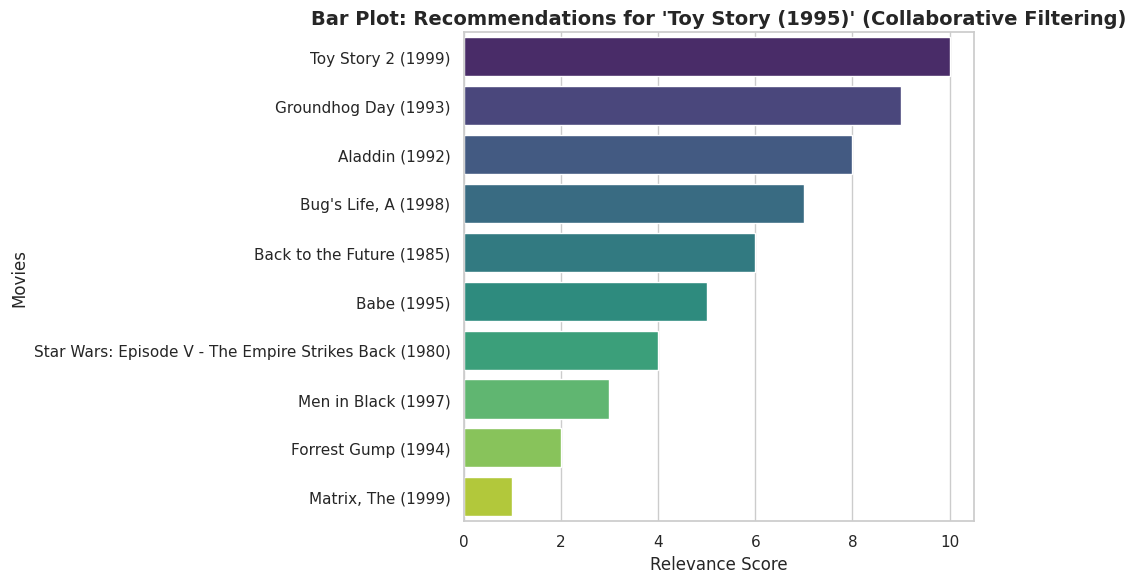

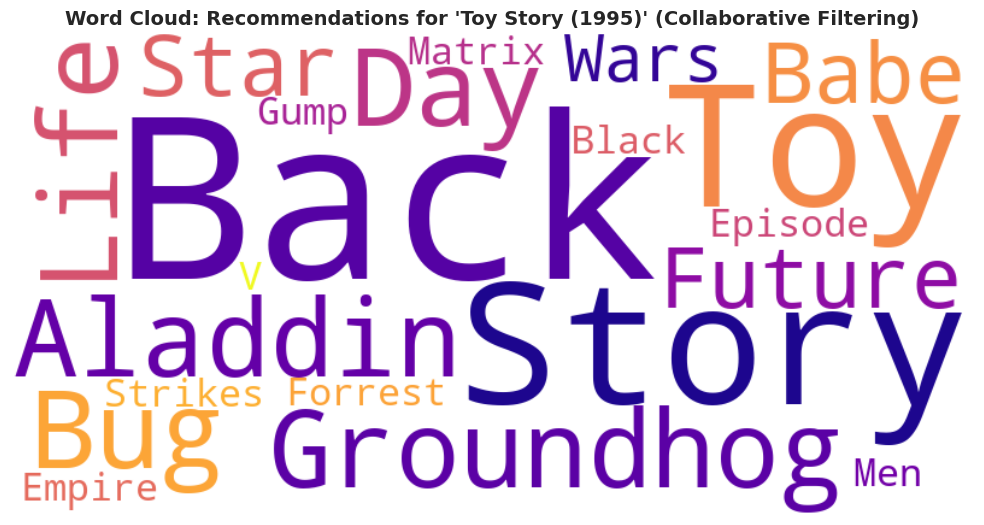

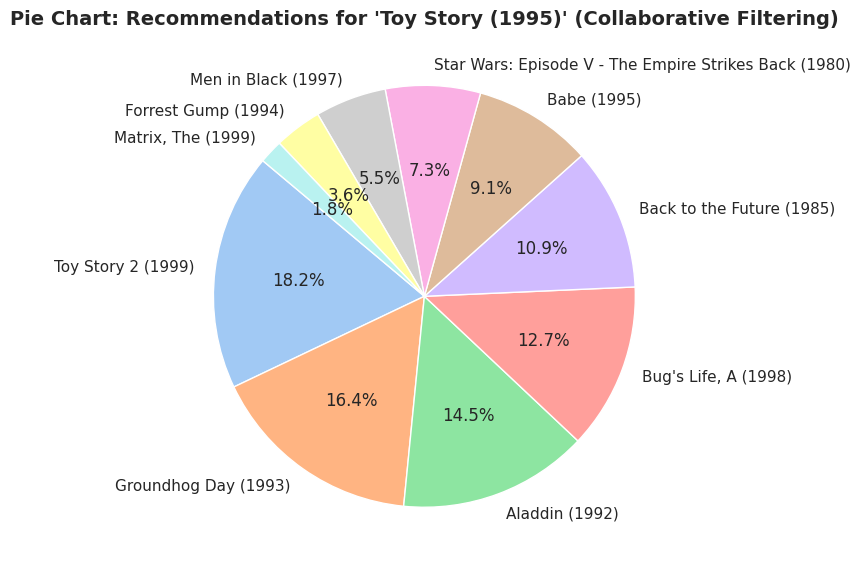

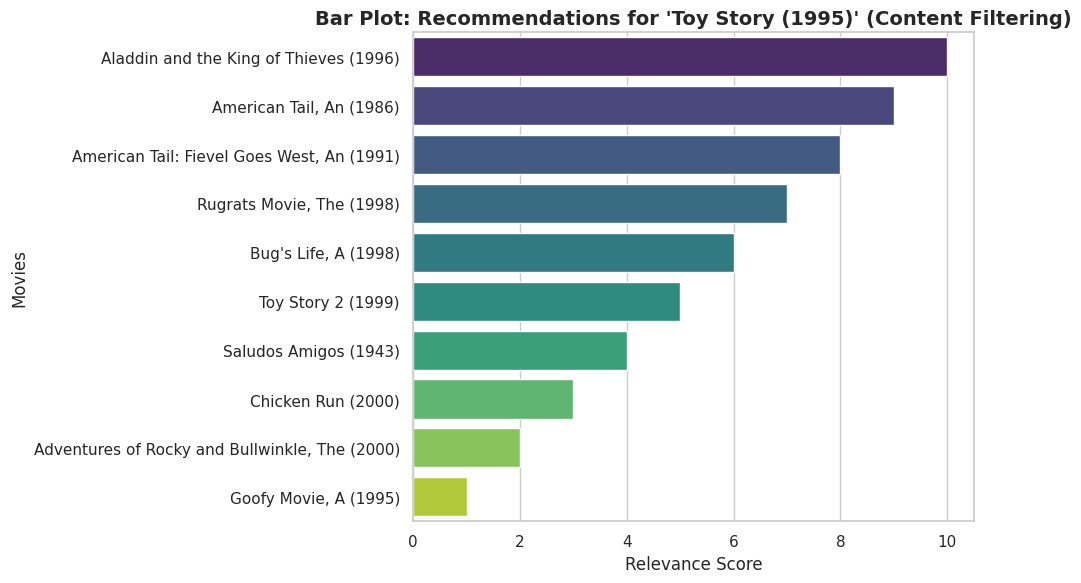

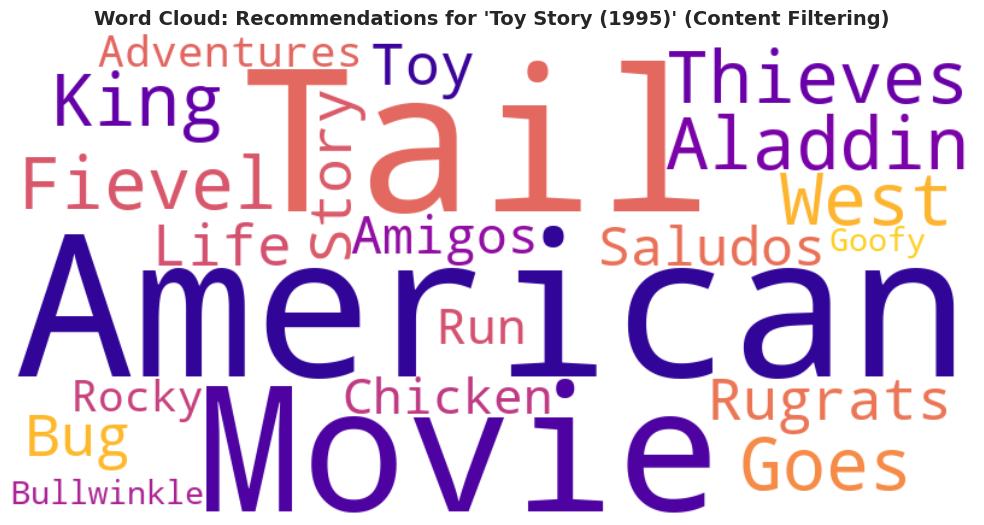

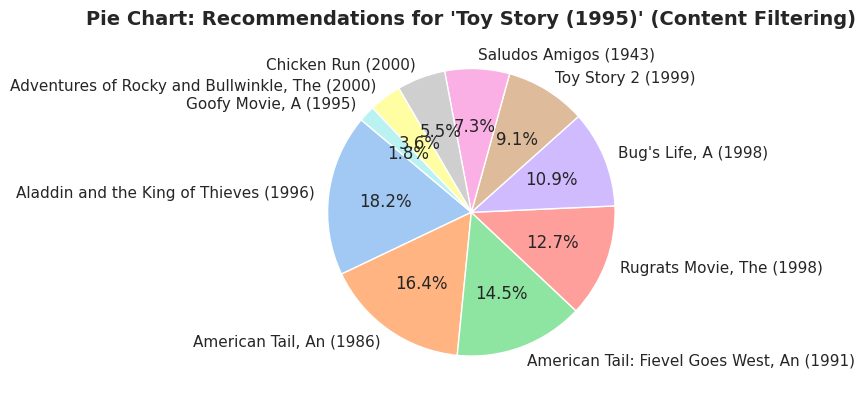

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

def visualize_recommendations(movie_title, recommendations, model_type):
    if isinstance(recommendations, pd.DataFrame):
        data = recommendations[['title', 'Similarity Score']]  # Extract the necessary columns for visualization
        data['Score'] = data['Similarity Score']  # Use the similarity score for visualization
        recommendations_list = data['title'].tolist()
        scores = data['Score'].tolist()
    else:
        data = pd.DataFrame({'Movie': recommendations, 'Score': range(len(recommendations), 0, -1)})
        recommendations_list = data['Movie'].tolist()
        scores = data['Score'].tolist()

    sns.set_theme(style="whitegrid")
    
    # 1. Horizontal Bar Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=data, 
        y='Movie', 
        x='Score', 
        palette="viridis"
    )
    plt.title(f"Bar Plot: Recommendations for '{movie_title}' ({model_type.title()} Filtering)", fontsize=14, weight='bold')
    plt.xlabel('Relevance Score', fontsize=12)
    plt.ylabel('Movies', fontsize=12)
    plt.tight_layout()
    plt.show()

    # 2. Word Cloud for Movie Titles
    wordcloud = WordCloud(
        background_color='white',
        width=800,
        height=400,
        colormap='plasma'
    ).generate(" ".join(recommendations_list))
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud: Recommendations for '{movie_title}' ({model_type.title()} Filtering)", fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

    # 3. Pie Chart of Recommendations
    plt.figure(figsize=(8, 8))
    colors = sns.color_palette('pastel')[0:len(recommendations_list)]
    plt.pie(scores, labels=recommendations_list, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title(f"Pie Chart: Recommendations for '{movie_title}' ({model_type.title()} Filtering)", fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

movie_name = "Toy Story (1995)"
visualize_recommendations(movie_name,collab_recommendations, model_type='collaborative')

movie_name = "Toy Story (1995)"
visualize_recommendations(movie_name,content_recommendations, model_type='content')

#### **SVD Model**

In [54]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix

# Create a pivot table where rows are user_ids, columns are movie_ids, and values are ratings
user_movie_matrix = rating.pivot(index='userid', columns='movieid', values='rating').fillna(0)

# Convert the dataframe to a sparse matrix format
matrix = csr_matrix(user_movie_matrix.values)

# Apply SVD (Singular Value Decomposition)
svd = TruncatedSVD(n_components=50, random_state=42)
matrix_svd = svd.fit_transform(matrix)

# Reconstruct the rating matrix
reconstructed_matrix = svd.inverse_transform(matrix_svd)
reconstructed_matrix = pd.DataFrame(reconstructed_matrix, columns=user_movie_matrix.columns, index=user_movie_matrix.index)

# Calculate Mean Squared Error
mse = mean_squared_error(user_movie_matrix.values, reconstructed_matrix.values)

# Recommend movies for a specific user (e.g., User 1)
def recommend_movies_for_user(user_id, top_n=10):
    # Get the user's original ratings
    user_ratings = user_movie_matrix.loc[user_id]
    
    # Get predicted ratings for the user
    user_predictions = reconstructed_matrix.loc[user_id]
    
    # Filter out movies the user has already rated
    movies_not_watched = user_ratings[user_ratings == 0].index
    recommendations = user_predictions[movies_not_watched].sort_values(ascending=False).head(top_n)
    
    # Map movie IDs to titles
    recommendations = pd.DataFrame({
        'Movie ID': recommendations.index,
        'Predicted Rating': recommendations.values
    })
    recommendations = recommendations.merge(movies[['movieid', 'title']], left_on='Movie ID', right_on='movieid')
    return recommendations[['title', 'Predicted Rating']]

# Visualize top 10 recommended movies for User 1
user_id = 1
recommendations = recommend_movies_for_user(user_id, top_n=10)

print("Top 10 Recommendations:")
print(recommendations)

Top 10 Recommendations:
                              title  Predicted Rating
0             Lion King, The (1994)          2.645647
1  Shawshank Redemption, The (1994)          2.591461
2                       Babe (1995)          2.454103
3        Little Mermaid, The (1989)          2.244342
4                   Fantasia (1940)          1.975137
5           Jungle Book, The (1967)          1.733368
6            Sleeping Beauty (1959)          1.725543
7         Lady and the Tramp (1955)          1.719660
8            American Beauty (1999)          1.702523
9    Raiders of the Lost Ark (1981)          1.663852


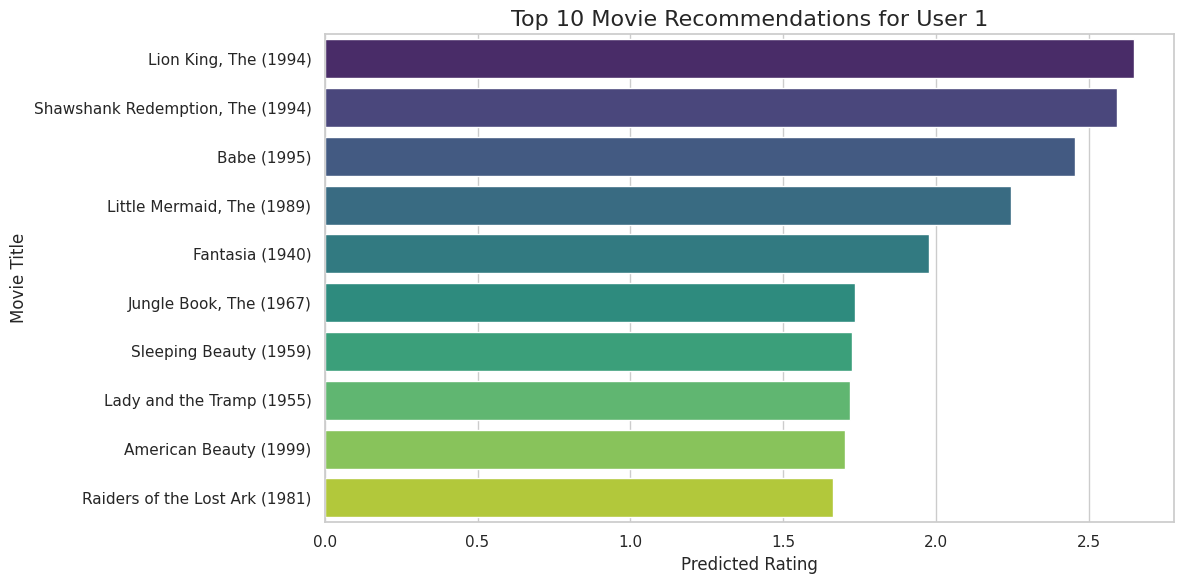

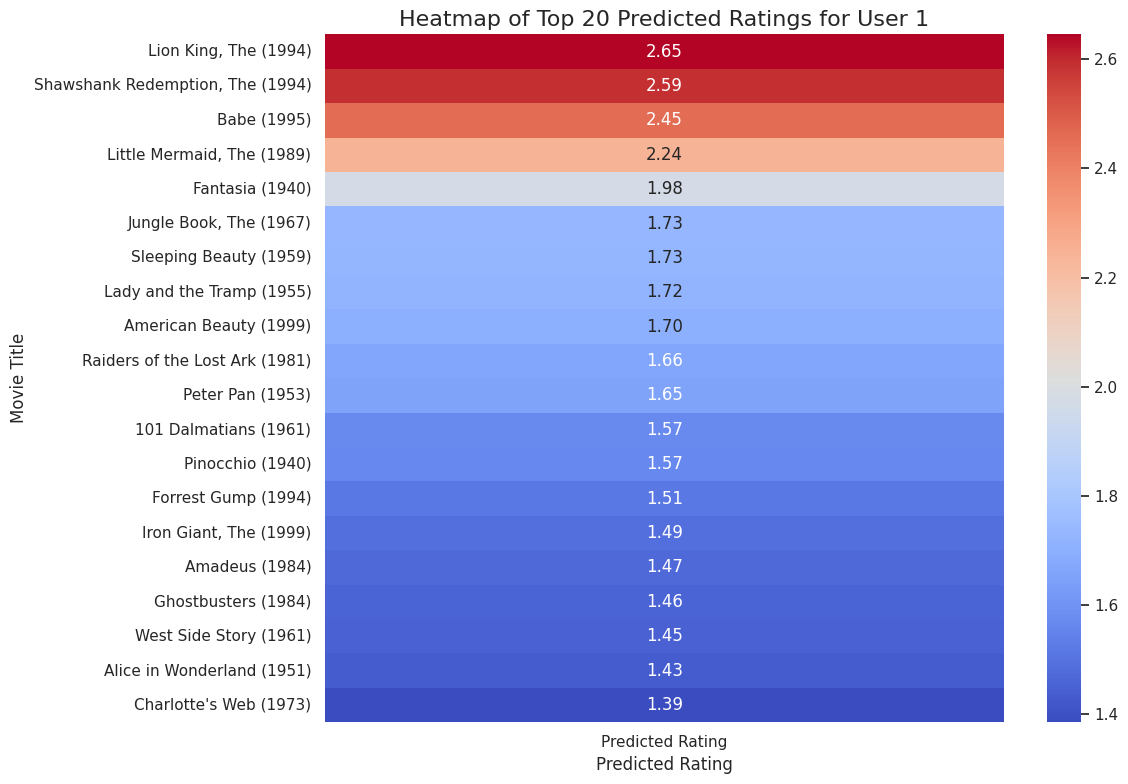

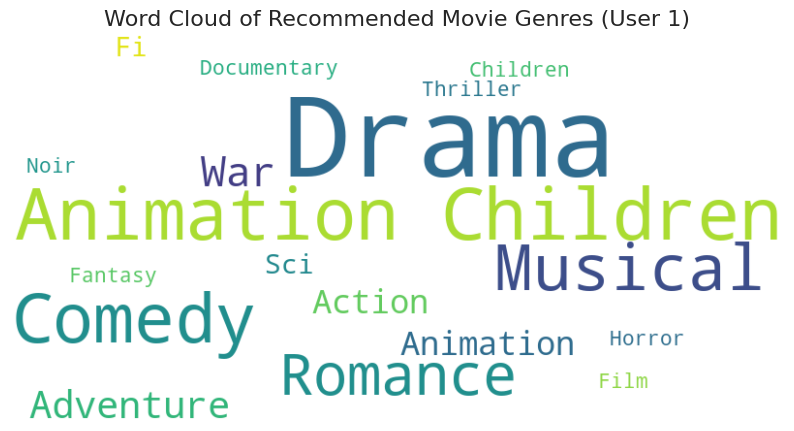

In [56]:
from wordcloud import WordCloud

# Heatmap of predicted ratings for a specific user
def plot_heatmap_for_user(user_id):
    user_predictions = reconstructed_matrix.loc[user_id]
    user_ratings = user_movie_matrix.loc[user_id]
    
    # Get movies not watched by the user
    unwatched_movies = user_ratings[user_ratings == 0].index
    unwatched_predictions = user_predictions[unwatched_movies]
    
    # Create a dataframe for heatmap
    heatmap_data = unwatched_predictions.sort_values(ascending=False).head(20)
    heatmap_data = heatmap_data.to_frame(name='Predicted Rating').reset_index()
    heatmap_data = heatmap_data.merge(movies[['movieid', 'title']], left_on='movieid', right_on='movieid')
    heatmap_data.set_index('title', inplace=True)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data[['Predicted Rating']], annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
    plt.title(f'Heatmap of Top 20 Predicted Ratings for User {user_id}', fontsize=16)
    plt.xlabel('Predicted Rating', fontsize=12)
    plt.ylabel('Movie Title', fontsize=12)
    plt.tight_layout()
    plt.show()

# Word Cloud of recommended genres
def plot_genre_wordcloud(user_id, top_n=50):
    recommendations = recommend_movies_for_user(user_id, top_n)
    genres = movies[movies['title'].isin(recommendations['title'])]['genres'].str.split('|').sum()
    genre_text = ' '.join(genres)
    
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(genre_text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of Recommended Movie Genres (User {user_id})', fontsize=16)
    plt.show()

# Visualize recommendations
user_id = 1 
recommendations = recommend_movies_for_user(user_id, top_n=10)

# Bar plot of top recommendations
plt.figure(figsize=(12, 6))
sns.barplot(
    data=recommendations,
    x='Predicted Rating',
    y='title',
    palette='viridis'
)
plt.title(f'Top 10 Movie Recommendations for User {user_id}', fontsize=16)
plt.xlabel('Predicted Rating', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)
plt.tight_layout()
plt.show()

# Heatmap visualization
plot_heatmap_for_user(user_id)

# Word cloud visualization
plot_genre_wordcloud(user_id, top_n=50)

#### **K-Mean Clustering**

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


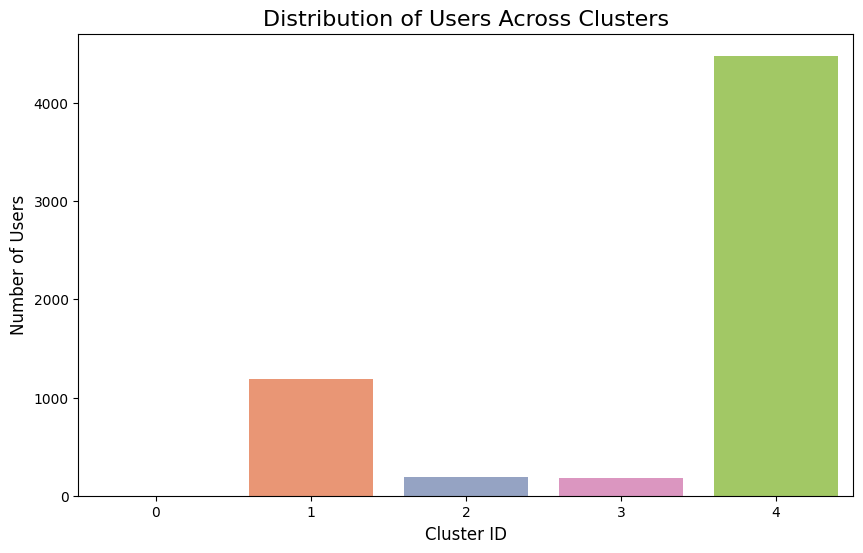

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize the data for clustering
scaler = StandardScaler()
scaled_matrix = scaler.fit_transform(user_movie_matrix)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(scaled_matrix)

# Map clusters to users
user_clusters = pd.DataFrame({'userid': user_movie_matrix.index, 'cluster': clusters})

# Compute average ratings for each cluster
cluster_means = user_movie_matrix.copy()
cluster_means['cluster'] = clusters  # Add cluster information
cluster_avg_ratings = cluster_means.groupby('cluster').mean().mean(axis=1)

# Assign predicted labels based on cluster averages
cluster_labels = cluster_means['cluster'].map(cluster_avg_ratings >= threshold).astype(int)


# Apply KMeans clustering with 5 clusters (you can tune this parameter)
kmeans = KMeans(n_clusters=5, random_state=42)
user_movie_matrix['cluster'] = kmeans.fit_predict(scaled_matrix)

# Visualizing the cluster distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=user_movie_matrix, palette='Set2')
plt.title('Distribution of Users Across Clusters', fontsize=16)
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.show()